M54 data - Part 3
=================

First, we set up the data:

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
m54_data.logarithmically_resample(dv=50.)

ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



Let us make a function that brings the fitted distribution function in the correct orientation.

In [188]:
%matplotlib inline

def orient_image(f):
    """
    Transform the distribution function that goes into observation operator into an image
    that has the correct orientation for visualisation.
    """
    image = f
    # Have to flip.
    image = np.flipud(image)
    return image

Recreating the PPXF fit
-----------------------

Next, we fit the data using ``ppxf``

In [189]:
from ppxf import ppxf

npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=10,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask
)

f_ppxf = np.reshape(ppxf_fit.weights, ssps.par_dims)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.008    -0.003
chi2/DOF: 1.143; degree = -1; mdegree = 10
method = capfit; Jac calls: 9; Func calls: 139; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 636


Next, we compute the MAP estimate from our Bayesian model:

First, correct the templates using the fitted polynomial.

In [190]:
continuum_distorition = ppxf_fit.mpoly
# add an extra element to the end of array to account for one that we chopped off earlier
continuum_distorition = np.concatenate([continuum_distorition, [continuum_distorition[-1]]])

import copy
ssps_corrected = copy.deepcopy(ssps)
ssps_corrected.Xw = (ssps_corrected.Xw.T * continuum_distorition).T

Adapt the observation operator:

In [191]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(ssps=ssps_corrected,
                        dv=ssps_corrected.dv,
                        do_log_resample=False)
G_orig = ObservationOperator(ssps=ssps, dv=ssps.dv, do_log_resample=False)

Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


We set $\theta_v$ equal to the PPXF fit. We have to invert the sign of $h_3$.

In [192]:
theta_v = np.array([146, 3, 1., 0., 0., 0.008, -0.003])

Rescale the data.

In [193]:
mask = m54_data.mask
y = m54_data.y[mask]
y_sd = m54_data.noise_level[mask]

ppxf_scale = np.linalg.norm(f_ppxf)
s = ppxf_scale
y_scaled = y / s
y_sd_scaled = y_sd / s

With this, lets compute the MAP estimate for $g = f / s$.

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 5293.523736511346
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.7550108452560469   |  1.3157704092936484e-13 |    9.558396769562965    |           1.0           |    1.0869946479797363   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.7550108452560472   |  1.313

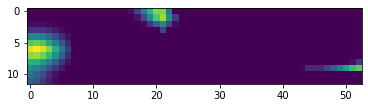

In [194]:
%matplotlib inline

from uq4pk_fit.inference import ForwardOperator, StatModel


forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps_corrected, dv=ssps_corrected.dv,
                                   do_log_resample=False)
# Fit the model
model = StatModel(y=y_scaled, y_sd=y_sd_scaled, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.beta1 = 10.
fitted_model = model.fit()
g_map = fitted_model.f_map
f_map = s * g_map.clip(min=0.)  # Enforce nonnegativity

im_map = orient_image(f_map)
plt.imshow(im_map)


Also, compute the unregularized (maximum likelihood) fit.

In [195]:
model.beta1 = 1e-12

fitted_model_unregularized = model.fit()
g_ml = fitted_model_unregularized.f_map
f_ml = s * g_ml.clip(min=0.)



Starting the constrained Gauss-Newton method. Cost at starting value: 5293.523736436733
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.621242708712421    |  3.835845510582331e-10  |    124.40868367898906   |           1.0           |    1.2043180465698242   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.6212427087124208   |   3.82

After a week of trial and error, Prashin noted that there is a significant difference
between our observation operator and the PPXF fit that has to do with the age-metallicity
volume elements. In order to make the estimates from our custom implementation comparable with the PPXF fit,
we have to perform the following rescaling:

In [196]:
delta_zt = ssps.delta_z[:, np.newaxis] * ssps.delta_t[np.newaxis]

f_map_scaled = delta_zt * f_map
f_ml_scaled = delta_zt * f_ml

Finally, let us compare the images:

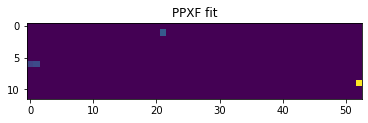

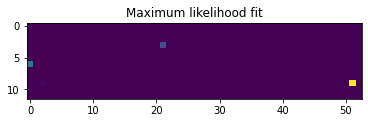

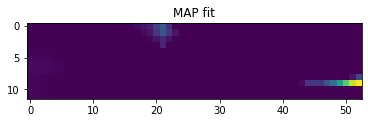

In [197]:
im_ppxf = orient_image(f_ppxf)
im_map = orient_image(f_map_scaled)
im_ml = orient_image(f_ml_scaled)

plt.imshow(im_ppxf)
plt.title("PPXF fit")
plt.show()

plt.imshow(im_ml)
plt.title("Maximum likelihood fit")
plt.show()

plt.imshow(im_map)
plt.title("MAP fit")
plt.show()

They all look much more similar than before! However, the maximum likelihood fit is not identical
to the PPXF fit, in constrast to what we would expect. I experimented a little bit, and I found something that might
be the cause: If we use just a little bit of regularization...

In [198]:
model.beta1 = 1e-2

fitted_model_mildly_regularized = model.fit()
g_mr = fitted_model_mildly_regularized.f_map
f_mr = s * g_mr.clip(min=0.)



Starting the constrained Gauss-Newton method. Cost at starting value: 5293.523736436807
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.5816527385270763   |  5.1995877221877596e-12 |    67.47357989473032    |           1.0           |    1.212470531463623    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.581652738527075    |  5.212

... we obtain something that looks (almost) exactly like the PPXF fit:

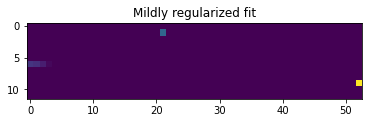

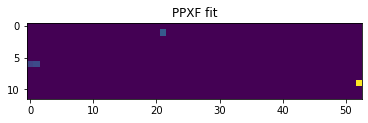

In [199]:
f_mr_scaled = delta_zt * f_mr
im_mr = orient_image(f_mr_scaled)

plt.imshow(im_mr)
plt.title("Mildly regularized fit")
plt.show()

plt.imshow(im_ppxf)
plt.title("PPXF fit")
plt.show()

So, my theory is that either PPXF or the least-squares solver it internally calls use a little bit
of regularization (which would be sensible, as otherwise the optimization problem becomes unstable),
and so the PPXF fit corresponds not to the maximum likelihood fit but to a mildly regularized MAP
fit.

Finally, let us compare the data fit:

In [200]:
ydim = y.size
def data_fit(z):
    scaled_fit = np.linalg.norm((z - y) / y_sd) / ydim
    return scaled_fit

y_map = G.evaluate(f_map, theta_v)[mask]
y_ml = G.evaluate(f_ml, theta_v)[mask]
y_mr = G.evaluate(f_mr, theta_v)[mask]
y_ppxf = z = ppxf_fit.bestfit[ppxf_fit.goodpixels]

data_fit_map = data_fit(y_map)
data_fit_ml = data_fit(y_ml)
data_fit_mr = data_fit(y_mr)
data_fit_ppxf = data_fit(y_ppxf)

print(f"Data fit of PPXF: {data_fit_ppxf}")
print(f"Data fit of the MAP estimate: {data_fit_map}")
print(f"Data fit of the ML estimate: {data_fit_ml}")
print(f"Data fit of a mildly regularized MAP estimate: {data_fit_mr}")


Data fit of PPXF: 0.01813632622289025
Data fit of the MAP estimate: 0.020349985637801885
Data fit of the ML estimate: 0.01894719175846341
Data fit of a mildly regularized MAP estimate: 0.018182039895021505
